In [1]:
import torch
import torchvision

print("Pytorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

# Download the default model from here: 
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth 

import numpy as np
import matplotlib.pyplot as plt
import cv2

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

Pytorch version: 2.4.0
Torchvision version: 0.19.0
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-hnkmuzew
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-hnkmuzew
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2024-10-26 23:05:25--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.14, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: 'sam_vit_h_4b8939.pth'

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   306MB/s    in 8.8s    

2024-10-26 23:05:34 (277 MB/s) - 'sam_vit_h

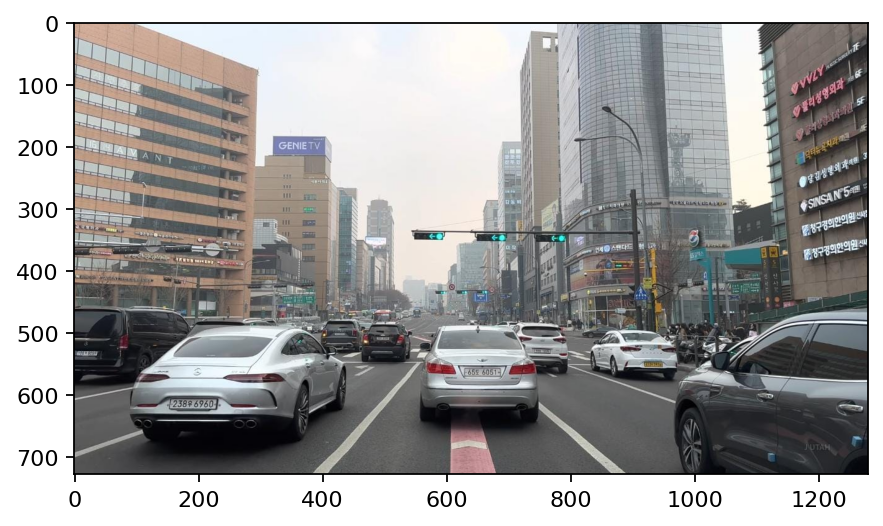

In [19]:
image = cv2.imread('/kaggle/input/image-segment/cars_on_road.jpeg')

# Change the format of image that is from BGR(cv2 format) to RGB (matplotlib format)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# show the image
plt.figure(dpi=160)
plt.imshow(image)

In [3]:
sam_checkpoint = "/kaggle/working/sam_vit_h_4b8939.pth"

In [4]:
model_type = "vit_h"


In [5]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

/opt/conda/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [7]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100    # Requires open-cv to run post-processing
)

In [8]:
masks = mask_generator.generate(image)

print(len(masks))
print(masks[0].keys())

35
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [11]:
!pip install matplotlib numpy

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def show_anns(anns, image):
    """Takes a list of masks as an input and visualizes them on an Image"""
    if len(anns) == 0:
        return 

    # Sort the masks by their area in descending order
    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Create a new image that is the same size as the original image
    img = np.ones((image.shape[0], image.shape[1], 4))
    
    img[:, :, 3] = 0  # Sets the alpha channel of the new image to 0.
    
    # Iterate over sorted masks and fill in the corresponding pixels in new image with random color.
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])  # Random color with alpha
        img[m] = color_mask
        
    ax.imshow(img)

# Assuming 'image' is your original frame and 'masks' are the segmentation masks
plt.figure(figsize=(10, 10)) 
plt.imshow(image)
show_anns(masks, image)

# Save the figure
output_image_path = 'segmented_image.png'
plt.axis('off')  # Turn off axis numbers and ticks
plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
plt.close()  # Close the figure to avoid displaying it again

# Download the image (Kaggle allows direct downloads via the API)
from IPython.display import FileLink
FileLink(output_image_path)  # Provide a link to download the image


/kaggle/working/segmented_image.png

In [14]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.6/877.6 kB 22.0 MB/s eta 0:00:0000:01


In [15]:
from ultralytics import YOLO
import math

model = YOLO('yolov8n.pt')    # I am using yolo version 8 Nano weights, but one can even use Large or Medium as weights

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 126MB/s]


In [16]:
# From the COCO Dataset by Microsoft, let's create a list of classes that YOLO could be able to detect
classnames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat", "traffic light",
              "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
              "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
              "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
              "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa",
              "potted plant", "bed", "dining table", "toilet", "tv monitor", "laptop", "mouse", "remote", "keyboard",
              "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"]

In [17]:
image.shape

(1020, 1920, 3)

In [22]:
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np

def show_bbox_and_label(image, model, classnames):
    results = model(image)
    
    for r in results:    # for number of OBJECTS detected in the image
        boxes = r.boxes  # give me the bounding boxes of those objects detected in the image
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            w, h = x2 - x1, y2 - y1
            
            print(f"x1,y1 coordinate: {(x1,y1)}\nx2,y2 coordinate: {x2,y2}\nWidth: {w}\nHeight:{h}")
            
            # Find out the confidence
            conf = math.ceil(box.conf[0] * 100) / 100
            print(f"Confidence of box: {conf}\n", "-" * 30)
            
            # Find out the class name
            cls = int(box.cls[0])
            
            # Draw the rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 3)
            
            # Now, let's put the text on rectangle
            FONT = cv2.FONT_HERSHEY_SIMPLEX
            COLOR = (0, 0, 0)
            THICKNESS = 3
            ORG = (max(0, x1), max(35, y1 - 10))
            
            cv2.putText(image, f"{classnames[cls]} {conf}", ORG, FONT, 1, COLOR, THICKNESS)
    
    plt.figure(figsize=(15, 8), dpi=120)
    plt.imshow(image)
    
    # Save the modified image
    output_image_path = 'image_with_bboxes.png'
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the figure to avoid displaying it again
    
    # Return the path for downloading
    return output_image_path

# Assuming 'image' is your input image, 'model' is your detection model, and 'classnames' is the list of class names
output_image_path = show_bbox_and_label(image, model, classnames)

# Provide a link to download the image
from IPython.display import FileLink
FileLink(output_image_path)  # Create a download link for the image



0: 384x640 3 cars, 1 bus, 1 truck, 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
x1,y1 coordinate: (966, 464)
x2,y2 coordinate: (1276, 718)
Width: 310
Height:254
Confidence of box: 0.92
 ------------------------------
x1,y1 coordinate: (84, 481)
x2,y2 coordinate: (437, 679)
Width: 353
Height:198
Confidence of box: 0.9
 ------------------------------
x1,y1 coordinate: (548, 487)
x2,y2 coordinate: (766, 654)
Width: 218
Height:167
Confidence of box: 0.37
 ------------------------------
x1,y1 coordinate: (826, 490)
x2,y2 coordinate: (970, 575)
Width: 144
Height:85
Confidence of box: 0.34
 ------------------------------
x1,y1 coordinate: (0, 399)
x2,y2 coordinate: (213, 578)
Width: 213
Height:179
Confidence of box: 0.31
 ------------------------------


/kaggle/working/image_with_bboxes.png